# Imports and Setup

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import segmentation_models_pytorch as smp
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from collections import defaultdict

import mlflow
import optuna
import optuna.visualization as viz
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.loggers import MLFlowLogger

# Set random seed for reproducibility
pl.seed_everything(42, workers=True)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Seed set to 42


Using device: cuda


# Classes and Definitions

In [20]:
class DepthDistillationDataset(Dataset):
    def __init__(self, img_dir, depth_dir, conf_dir, is_train=False, prob=None):
        """
        Args:
            img_dir: Directory with input images
            depth_dir: Directory with teacher depth maps (.npy files)
            conf_dir: Directory with teacher confidence maps (.npy files)
            is_train: Whether this is training dataset (for augmentation)
            prob: Dictionary with augmentation probabilities 
                  {'horizontal_flip': float, 'color_jitter': float}
        """
        self.img_dir = img_dir
        self.depth_dir = depth_dir
        self.conf_dir = conf_dir
        self.is_train = is_train
        self.prob = prob if prob is not None else {'horizontal_flip': 0.5, 'color_jitter': 0.5}
        
        # Get list of images
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load teacher predictions
        depth_path = os.path.join(self.depth_dir, img_name.replace('.png', '.npy'))
        teacher_depth = np.load(depth_path)
        
        # Load confidence maps
        conf_path = os.path.join(self.conf_dir, img_name.replace('.png', '.npy'))
        teacher_conf = np.load(conf_path)
        
        # Apply synchronized augmentations if training
        if self.is_train:
            # Random horizontal flip
            if torch.rand(1).item() < self.prob['horizontal_flip']:
                image = TF.hflip(image)
                teacher_depth = np.fliplr(teacher_depth).copy()
                teacher_conf = np.fliplr(teacher_conf).copy()
            
            # Color jitter (only on image)
            if torch.rand(1).item() < self.prob['color_jitter']:
                color_jitter = T.ColorJitter(brightness=0.25, contrast=0.25)
                image = color_jitter(image)
        
        # Convert to tensors
        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        teacher_depth = torch.from_numpy(teacher_depth).float()
        teacher_conf = torch.from_numpy(teacher_conf).float()
        
        return image, teacher_depth, teacher_conf

In [21]:
class DataModule(pl.LightningDataModule):
    def __init__(self, 
                 train_img_dir, train_depth_dir, train_conf_dir,
                 val_img_dir, val_depth_dir, val_conf_dir,
                 test_img_dir, test_depth_dir, test_conf_dir,
                 batch_size=4, 
                 num_workers=2,
                 prob=None):
        """
        Args:
            train_img_dir, train_depth_dir, train_conf_dir: Training data directories
            val_img_dir, val_depth_dir, val_conf_dir: Validation data directories
            test_img_dir, test_depth_dir, test_conf_dir: Test data directories
            batch_size: Batch size for dataloaders
            num_workers: Number of workers for dataloaders
            prob: Dictionary with augmentation probabilities
        """
        super().__init__()
        self.train_img_dir = train_img_dir
        self.train_depth_dir = train_depth_dir
        self.train_conf_dir = train_conf_dir
        self.val_img_dir = val_img_dir
        self.val_depth_dir = val_depth_dir
        self.val_conf_dir = val_conf_dir
        self.test_img_dir = test_img_dir
        self.test_depth_dir = test_depth_dir
        self.test_conf_dir = test_conf_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.prob = prob if prob is not None else {'horizontal_flip': 0.5, 'color_jitter': 0.5}
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = DepthDistillationDataset(
                img_dir=self.train_img_dir,
                depth_dir=self.train_depth_dir,
                conf_dir=self.train_conf_dir,
                is_train=True,
                prob=self.prob
            )
            self.val_dataset = DepthDistillationDataset(
                img_dir=self.val_img_dir,
                depth_dir=self.val_depth_dir,
                conf_dir=self.val_conf_dir,
                is_train=False
            )
        
        if stage == 'test' or stage is None:
            self.test_dataset = DepthDistillationDataset(
                img_dir=self.test_img_dir,
                depth_dir=self.test_depth_dir,
                conf_dir=self.test_conf_dir,
                is_train=False
            )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

In [22]:
class DepthDistillationLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.7):
        """
        Args:
            temperature: Temperature for softening teacher predictions
            alpha: Weight for soft loss (1-alpha for hard loss)
        """
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()
        
    def forward(self, student_pred, teacher_depth, teacher_conf):
        """
        For depth prediction, we use:
        - Soft loss: MSE between student and teacher predictions (weighted by confidence)
        - Hard loss: Direct MSE on depth values
        
        Args:
            student_pred: Student model predictions [B, 1, H, W]
            teacher_depth: Teacher depth maps [B, H, W]
            teacher_conf: Teacher confidence maps [B, H, W]
        """
        # Ensure correct shapes
        if student_pred.dim() == 4:
            student_pred = student_pred.squeeze(1)  # [B, H, W]
        
        # Soft loss: Confidence-weighted MSE with teacher
        # Higher confidence areas have more influence
        soft_loss = self.mse_loss(
            student_pred * teacher_conf, 
            teacher_depth * teacher_conf
        )
        
        # Hard loss: Direct MSE with teacher depth
        hard_loss = self.mse_loss(student_pred, teacher_depth)
        
        # Combined loss
        total_loss = self.alpha * soft_loss + (1 - self.alpha) * hard_loss
        
        return total_loss, soft_loss, hard_loss

In [23]:
class DepthDistillationModule(pl.LightningModule):
    def __init__(self, student_model, lr=3e-4, temperature=4.0, alpha=0.7, weight_decay=0.0):
        super().__init__()
        self.student = student_model
        self.lr = lr
        self.weight_decay = weight_decay
        
        self.criterion = DepthDistillationLoss(temperature=temperature, alpha=alpha)
        
        # Track metrics
        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)
        self.test_step_outputs = defaultdict(float)
        
        # Save hyperparameters
        self.save_hyperparameters(ignore=['student_model'])
    
    def forward(self, x):
        """Forward pass through student model"""
        return self.student(x)
    
    def training_step(self, batch, batch_idx):
        images, teacher_depth, teacher_conf = batch
        
        # Get student predictions
        student_pred = self(images)
        
        # Calculate losses
        total_loss, soft_loss, hard_loss = self.criterion(
            student_pred, teacher_depth, teacher_conf
        )
        
        # FIXED: Only log on epoch, not on step
        self.log('train_loss', total_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('train_soft_loss', soft_loss, on_step=False, on_epoch=True, sync_dist=True)
        self.log('train_hard_loss', hard_loss, on_step=False, on_epoch=True, sync_dist=True)
        
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        images, teacher_depth, teacher_conf = batch
        
        # Get student predictions
        student_pred = self(images)
        
        # Calculate losses
        total_loss, soft_loss, hard_loss = self.criterion(
            student_pred, teacher_depth, teacher_conf
        )
        
        # FIXED: Only log on epoch, not on step
        self.log('val_loss', total_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('val_soft_loss', soft_loss, on_step=False, on_epoch=True, sync_dist=True)
        self.log('val_hard_loss', hard_loss, on_step=False, on_epoch=True, sync_dist=True)
        
        return total_loss
    
    def test_step(self, batch, batch_idx):
        """Test step for final evaluation"""
        images, teacher_depth, teacher_conf = batch
        
        # Get student predictions
        student_pred = self(images)
        
        # Calculate losses
        total_loss, soft_loss, hard_loss = self.criterion(
            student_pred, teacher_depth, teacher_conf
        )
        
        # FIXED: Only log on epoch, not on step
        self.log('test_loss', total_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('test_soft_loss', soft_loss, on_step=False, on_epoch=True, sync_dist=True)
        self.log('test_hard_loss', hard_loss, on_step=False, on_epoch=True, sync_dist=True)
        
        return total_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

# Dataset Creation

In [24]:
# Define your paths
TRAIN_IMG_DIR = '../CamVid/train/'
TRAIN_DEPTH_DIR = '../CamVid/train_labels/train_depths/'
TRAIN_CONF_DIR = '../CamVid/train_labels/train_confs/'
VAL_IMG_DIR = '../CamVid/val/'
VAL_DEPTH_DIR = '../CamVid/val_labels/val_depths/'
VAL_CONF_DIR = '../CamVid/val_labels/val_confs/'
TEST_IMG_DIR = '../CamVid/test/'
TEST_DEPTH_DIR = '../CamVid/test_labels/test_depths/'
TEST_CONF_DIR = '../CamVid/test_labels/test_confs/'

# Set random seed for reproducibility
pl.seed_everything(42, workers=True)

# Define augmentation probabilities
prob = {
    'horizontal_flip': 0.5,
    'color_jitter': 0.3
}

# Create DataModule
data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    train_conf_dir=TRAIN_CONF_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    val_conf_dir=VAL_CONF_DIR,
    test_img_dir=TEST_IMG_DIR,
    test_depth_dir=TEST_DEPTH_DIR,
    test_conf_dir=TEST_CONF_DIR,
    batch_size=4,
    num_workers=2,
    prob=prob
)

# Test it
data_module.setup()
print(f"Training samples: {len(data_module.train_dataset)}")
print(f"Validation samples: {len(data_module.val_dataset)}")
print(f"Test samples: {len(data_module.test_dataset)}")

Seed set to 42


Training samples: 369
Validation samples: 100
Test samples: 232


# MLFlow Setup

In [25]:
# Set tracking URI
mlflow.set_tracking_uri("mlruns")

# Set experiment name
EXPERIMENT_NAME = "depth_distillation_optimization"
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {EXPERIMENT_NAME}")

MLflow tracking URI: mlruns
Experiment: depth_distillation_optimization


# Optuna Objective Function

In [26]:
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization.
    Trains depth distillation model and logs to MLflow.
    """
    
    # Suggest hyperparameters
    params = {
        
        # Training parameters
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 24, 32]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
        'num_epochs': trial.suggest_int('num_epochs', 50, 150),
        
        # Distillation parameters
        'temperature': trial.suggest_float('temperature', 1.0, 10.0),
        'alpha': trial.suggest_float('alpha', 0.3, 0.9),
        
        # Augmentation probabilities
        'prob_horizontal_flip': trial.suggest_float('prob_horizontal_flip', 0.0, 0.7),
        'prob_color_jitter': trial.suggest_float('prob_color_jitter', 0.0, 0.7),
        
        # Optimizer parameters
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        
        # Fixed parameters
        'encoder_name': 'resnet18',
        'encoder_weights': 'imagenet',
        'num_workers': 2,
        'gradient_clip_val': 1.0,
    }
    
    # Start MLflow run (nested under parent run)
    with mlflow.start_run(nested=True, run_name=f"trial_{trial.number}"):
        
        # Log all hyperparameters
        mlflow.log_params(params)
        mlflow.log_param("trial_number", trial.number)
        
        # Create augmentation probabilities dict
        prob = {
            'horizontal_flip': params['prob_horizontal_flip'],
            'color_jitter': params['prob_color_jitter']
        }
        
        # Create data module
        data_module = DataModule(
            train_img_dir=TRAIN_IMG_DIR,
            train_depth_dir=TRAIN_DEPTH_DIR,
            train_conf_dir=TRAIN_CONF_DIR,
            val_img_dir=VAL_IMG_DIR,
            val_depth_dir=VAL_DEPTH_DIR,
            val_conf_dir=VAL_CONF_DIR,
            test_img_dir=TEST_IMG_DIR,
            test_depth_dir=TEST_DEPTH_DIR,
            test_conf_dir=TEST_CONF_DIR,
            batch_size=params['batch_size'],
            num_workers=params['num_workers'],
            prob=prob
        )
        
        # Create student model
        student = smp.Unet(
            encoder_name=params['encoder_name'],
            encoder_weights=params['encoder_weights'],
            in_channels=3,
            classes=1,
            activation=None
        )
        
        num_params = sum(p.numel() for p in student.parameters())
        mlflow.log_param("model_parameters", num_params)
        
        # Create Lightning module
        lightning_module = DepthDistillationModule(
            student_model=student,
            lr=params['learning_rate'],
            temperature=params['temperature'],
            alpha=params['alpha'],
            weight_decay=params['weight_decay']
        )
        
        # Setup MLflow logger for this trial
        mlflow_logger = MLFlowLogger(
            experiment_name=EXPERIMENT_NAME,
            run_id=mlflow.active_run().info.run_id
        )
        
        # Setup callbacks
        checkpoint_callback = ModelCheckpoint(
            monitor='val_loss',
            mode='min',
            filename=f'trial_{trial.number}_best',
            save_top_k=1,
            verbose=False
        )
        
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=15,
            mode='min',
            verbose=False
        )
        
        # Optuna pruning callback
        pruning_callback = PyTorchLightningPruningCallback(trial, monitor="val_loss")
        
        # Create trainer
        trainer = pl.Trainer(
            max_epochs=params['num_epochs'],
            logger=mlflow_logger,
            callbacks=[checkpoint_callback, early_stopping, pruning_callback],
            accelerator='gpu' if torch.cuda.is_available() else 'cpu',
            devices=1,
            gradient_clip_val=params['gradient_clip_val'],
            log_every_n_steps=10,
            enable_progress_bar=False,
            enable_model_summary=False
        )
        
        # Train the model
        try:
            trainer.fit(lightning_module, data_module)
            
            # FIXED: Get best validation loss properly with proper error handling
            if checkpoint_callback.best_model_score is not None:
                best_val_loss = float(checkpoint_callback.best_model_score)
            else:
                # Fallback: get from logged metrics
                best_val_loss = float(trainer.callback_metrics.get('val_loss', float('inf')))
            
            # Log best metrics
            mlflow.log_metric("best_val_loss", best_val_loss)
            mlflow.log_metric("epochs_trained", trainer.current_epoch)
            
            # Evaluate on test set
            test_results = trainer.test(
                lightning_module, 
                data_module, 
                ckpt_path=checkpoint_callback.best_model_path
            )
            
            if test_results:
                test_loss = test_results[0].get('test_loss', None)
                if test_loss:
                    mlflow.log_metric("test_loss", test_loss)
            
            # Log model artifact
            mlflow.pytorch.log_model(student, "model")
            
            # Log checkpoint (only if path exists)
            if checkpoint_callback.best_model_path:
                mlflow.log_artifact(checkpoint_callback.best_model_path, "checkpoints")
            
            print(f"Trial {trial.number}: val_loss={best_val_loss:.4f}, "
                  f"epochs={trainer.current_epoch}")
            
            return best_val_loss
            
        except optuna.TrialPruned:
            print(f"Trial {trial.number} pruned")
            raise
        except Exception as e:
            print(f"Trial {trial.number} failed: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for debugging
            mlflow.log_param("status", "failed")
            mlflow.log_param("error", str(e))
            return float('inf')

# Launch Optuna Study

In [ ]:
N_TRIALS = 3

# Safety: end any active runs before starting
mlflow.end_run()

# Set random seed for reproducibility
pl.seed_everything(42, workers=True)

# Create parent MLflow run
with mlflow.start_run(run_name="optuna_depth_distillation") as parent_run:
    
    # Log study configuration
    mlflow.log_param("optimization_metric", "val_loss")
    mlflow.log_param("n_trials", N_TRIALS)
    mlflow.log_param("model_type", "Depth_Distillation_UNet")
    mlflow.log_param("dataset", "CamVid")
    
    # Create Optuna study
    study = optuna.create_study(
        study_name="depth_distillation_optimization",
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
    )
    
    # Run optimization
    print("Starting Optuna optimization...")
    study.optimize(
        objective,
        n_trials=N_TRIALS,
        show_progress_bar=True
    )
    
    # Log best trial information
    best_trial = study.best_trial
    mlflow.log_params({f"best_{k}": v for k, v in best_trial.params.items()})
    mlflow.log_metric("best_val_loss", best_trial.value)
    
    print(f"\n{'='*60}")
    print("Optimization Complete!")
    print(f"{'='*60}")
    print(f"Best trial number: {best_trial.number}")
    print(f"Best validation loss: {best_trial.value:.4f}")
    print(f"Best hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")
    
    # Generate and log optimization visualizations
    print("\nGenerating optimization visualizations...")
    
    try:
        # Create plots directory
        os.makedirs("plots", exist_ok=True)
        
        # Plot optimization history
        fig1 = viz.plot_optimization_history(study)
        fig1.write_html("plots/optimization_history.html")
        mlflow.log_artifact("plots/optimization_history.html", "optimization_plots")
        
        # Plot parameter importances
        fig2 = viz.plot_param_importances(study)
        fig2.write_html("plots/param_importances.html")
        mlflow.log_artifact("plots/param_importances.html", "optimization_plots")
        
        # Plot parallel coordinate
        fig3 = viz.plot_parallel_coordinate(study)
        fig3.write_html("plots/parallel_coordinate.html")
        mlflow.log_artifact("plots/parallel_coordinate.html", "optimization_plots")
        
        # Plot slice
        fig4 = viz.plot_slice(study)
        fig4.write_html("plots/slice_plot.html")
        mlflow.log_artifact("plots/slice_plot.html", "optimization_plots")
        
        print("Optimization plots logged to MLflow")
        
    except Exception as e:
        print(f"Warning: Could not generate visualizations: {e}")

Seed set to 42
[I 2026-01-05 21:07:20,976] A new study created in memory with name: depth_distillation_optimization


Starting Optuna optimization...


  0%|          | 0/3 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=65` reached.
Restoring states from the checkpoint path at ./mlruns/128574694974248358/a4dc7cbf732a4064963a8ac246996e11/checkpoints/trial_0_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/128574694974248358/a4dc7cbf732a4064963a8ac246996e11/checkpoints/trial_0_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     3161.080810546875     │
│         test_loss         │     5111.53857421875      │
│      test_soft_loss       │     5540.54248046875      │
└───────────────────────────┴───────────────────────────┘

2026/01/05 21:23:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 21:24:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 0: val_loss=4565.0815, epochs=65
[I 2026-01-05 21:24:03,925] Trial 0 finished with value: 4565.08154296875 and parameters: {'batch_size': 16, 'learning_rate': 2.0513382630874486e-05, 'num_epochs': 65, 'temperature': 1.5227525095137953, 'alpha': 0.8197056874649611, 'prob_horizontal_flip': 0.42078050822024615, 'prob_color_jitter': 0.4956508044572318, 'weight_decay': 1.1527987128232402e-06}. Best is trial 0 with value: 4565.08154296875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


# Load Best Model

In [28]:
# Load best model
best_model = DepthDistillationModule.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    student_model=student
)
best_model.eval()

print("Best model loaded for evaluation!")

Best model loaded for evaluation!


# Visualize Test Predictions

Visualizing predictions on TEST set:


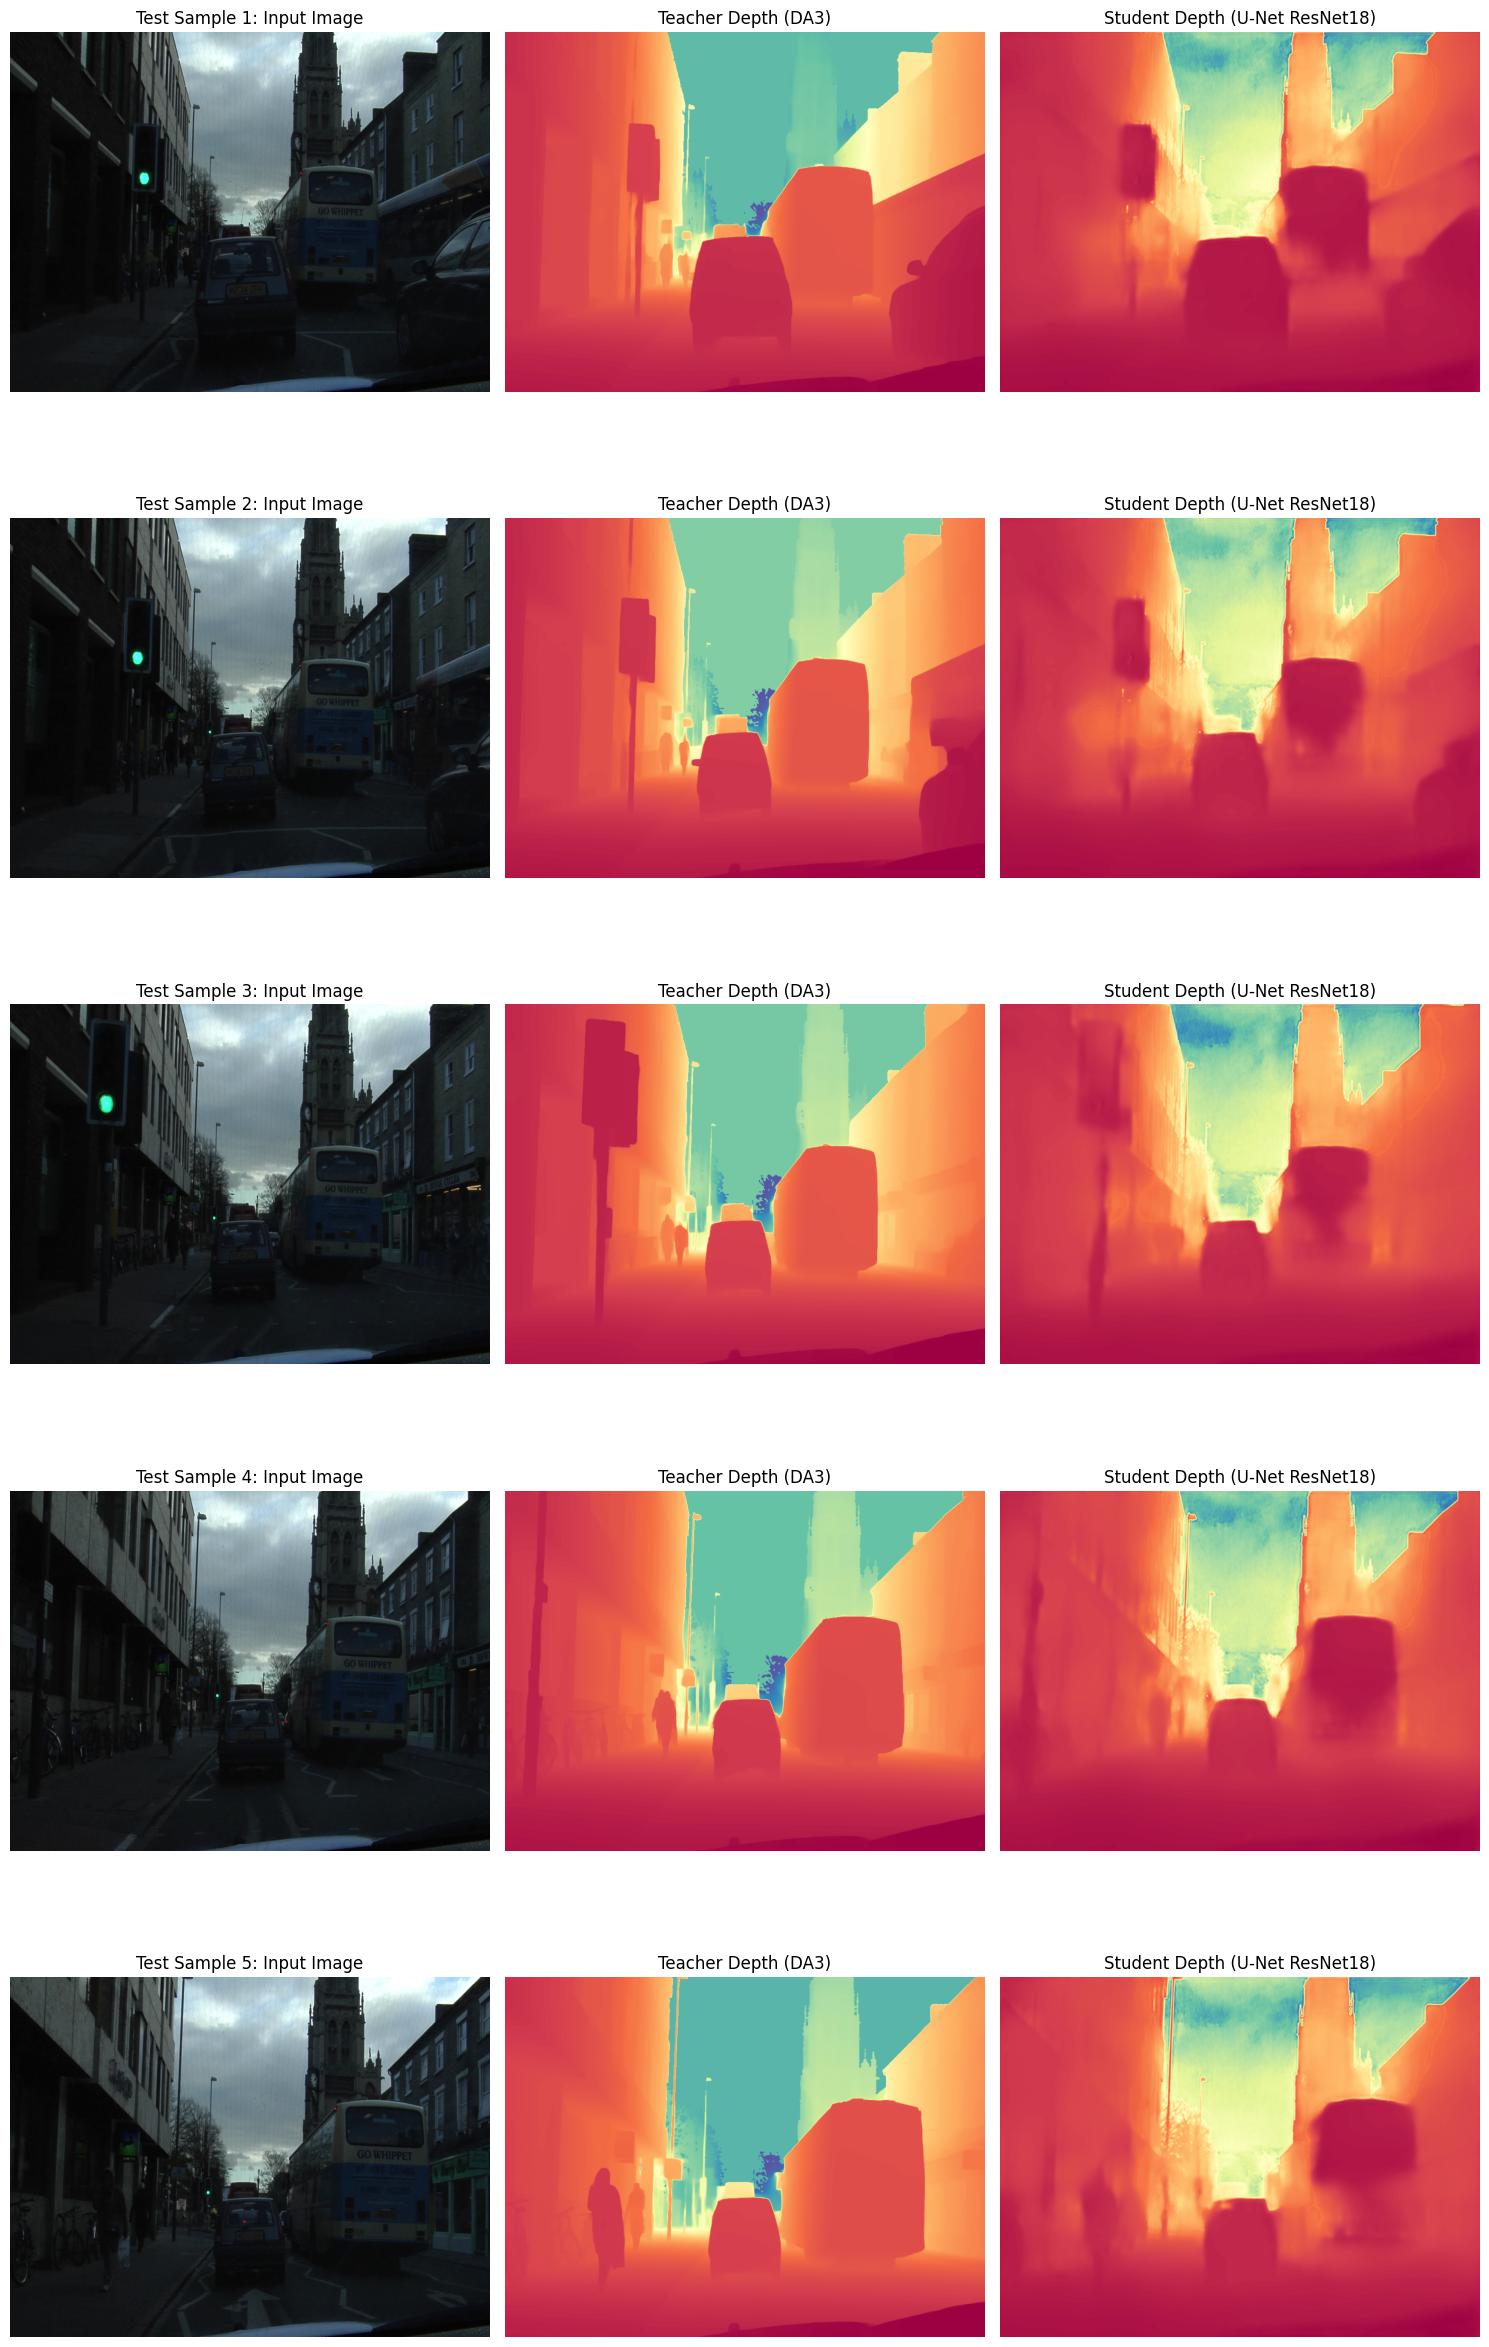

In [29]:
def visualize_predictions(model, dataset, num_samples=5, title_prefix="Test"):
    """Visualize student predictions vs teacher depth maps"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            image, teacher_depth, teacher_conf = dataset[i]
            
            # Get student prediction
            student_pred = model(image.unsqueeze(0).to(device))
            student_pred = student_pred.squeeze().cpu().numpy()
            
            # Denormalize image for visualization
            img_display = image.clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_display = img_display * std + mean
            img_display = torch.clamp(img_display, 0, 1)
            
            # Plot
            axes[i, 0].imshow(img_display.permute(1, 2, 0))
            axes[i, 0].set_title(f'{title_prefix} Sample {i+1}: Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(teacher_depth.numpy(), cmap='Spectral')
            axes[i, 1].set_title('Teacher Depth (DA3)')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(student_pred, cmap='Spectral')
            axes[i, 2].set_title('Student Depth (U-Net ResNet18)')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{title_prefix.lower()}_depth_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualizing predictions on TEST set:")
visualize_predictions(best_model.student, test_dataset, num_samples=5, title_prefix="Test")

# Calculate Metrics

In [22]:
def calculate_metrics(model, dataloader, split_name="Test"):
    """Calculate depth estimation metrics"""
    model.eval()
    
    total_mse = 0
    total_mae = 0
    total_abs_rel = 0  # Additional metric: absolute relative error
    num_samples = 0
    
    with torch.no_grad():
        for images, teacher_depth, _ in dataloader:
            images = images.to(device)
            teacher_depth = teacher_depth.to(device)
            
            # Get predictions
            student_pred = model(images).squeeze(1)
            
            # Calculate metrics
            mse = F.mse_loss(student_pred, teacher_depth)
            mae = F.l1_loss(student_pred, teacher_depth)
            
            # Absolute relative error
            abs_rel = torch.mean(torch.abs(student_pred - teacher_depth) / (teacher_depth + 1e-8))
            
            total_mse += mse.item() * images.size(0)
            total_mae += mae.item() * images.size(0)
            total_abs_rel += abs_rel.item() * images.size(0)
            num_samples += images.size(0)
    
    metrics = {
        'MSE': total_mse / num_samples,
        'MAE': total_mae / num_samples,
        'RMSE': np.sqrt(total_mse / num_samples),
        'Abs Rel': total_abs_rel / num_samples
    }
    
    print(f"\n{split_name} Set Metrics:")
    print("=" * 40)
    for metric_name, value in metrics.items():
        print(f"  {metric_name:12s}: {value:.4f}")
    print("=" * 40)
    
    return metrics

# Calculate metrics on TEST set
test_loader = data_module.test_dataloader()
test_metrics = calculate_metrics(best_model.student, test_loader, split_name="Test")

# Also calculate on validation for comparison
val_loader = data_module.val_dataloader()
val_metrics = calculate_metrics(best_model.student, val_loader, split_name="Validation")


Test Set Metrics:
  MSE         : 183.3943
  MAE         : 7.5133
  RMSE        : 13.5423
  Abs Rel     : 0.1601

Validation Set Metrics:
  MSE         : 101.8742
  MAE         : 5.4391
  RMSE        : 10.0933
  Abs Rel     : 0.1241


# Comparison

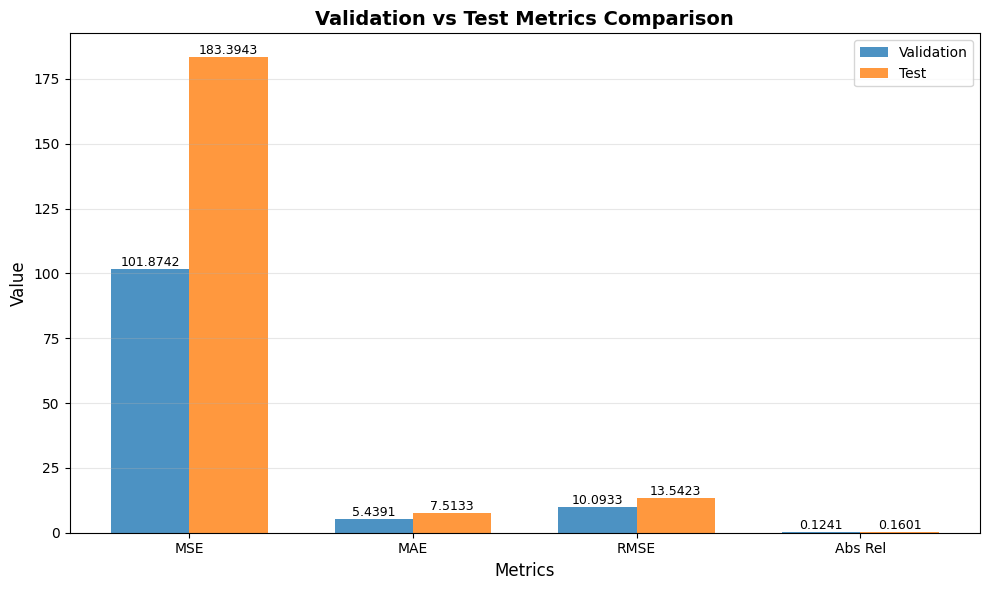

In [23]:
def plot_metric_comparison(test_metrics, val_metrics):
    """Compare test vs validation metrics"""
    metrics_names = list(test_metrics.keys())
    test_values = [test_metrics[m] for m in metrics_names]
    val_values = [val_metrics[m] for m in metrics_names]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, val_values, width, label='Validation', alpha=0.8)
    bars2 = ax.bar(x + width/2, test_values, width, label='Test', alpha=0.8)
    
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title('Validation vs Test Metrics Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot comparison
plot_metric_comparison(test_metrics, val_metrics)

# Test Set Detailed Analysis

In [24]:
def detailed_test_analysis(model, dataset, num_samples=10):
    """Perform detailed analysis on test samples"""
    model.eval()
    
    errors = []
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            image, teacher_depth, _ = dataset[i]
            
            # Get prediction
            student_pred = model(image.unsqueeze(0).to(device))
            student_pred = student_pred.squeeze().cpu()
            
            # Calculate per-sample error
            mse = F.mse_loss(student_pred, teacher_depth).item()
            mae = F.l1_loss(student_pred, teacher_depth).item()
            
            errors.append({
                'sample_idx': i,
                'MSE': mse,
                'MAE': mae
            })
    
    # Print per-sample results
    print("\nPer-Sample Test Results:")
    print("-" * 50)
    for error in errors:
        print(f"Sample {error['sample_idx']:3d}: MSE={error['MSE']:.4f}, MAE={error['MAE']:.4f}")
    
    # Statistical summary
    mse_values = [e['MSE'] for e in errors]
    mae_values = [e['MAE'] for e in errors]
    
    print("\nStatistical Summary:")
    print("-" * 50)
    print(f"MSE - Mean: {np.mean(mse_values):.4f}, Std: {np.std(mse_values):.4f}")
    print(f"MAE - Mean: {np.mean(mae_values):.4f}, Std: {np.std(mae_values):.4f}")

# Run detailed analysis
detailed_test_analysis(best_model.student, test_dataset, num_samples=10)


Per-Sample Test Results:
--------------------------------------------------
Sample   0: MSE=101.7383, MAE=6.1341
Sample   1: MSE=119.1738, MAE=6.6022
Sample   2: MSE=141.9300, MAE=7.6747
Sample   3: MSE=144.0683, MAE=6.8844
Sample   4: MSE=145.5139, MAE=7.1762
Sample   5: MSE=106.4998, MAE=6.0860
Sample   6: MSE=94.6828, MAE=6.2417
Sample   7: MSE=144.6272, MAE=7.7343
Sample   8: MSE=214.9075, MAE=9.9792
Sample   9: MSE=166.6352, MAE=9.2143

Statistical Summary:
--------------------------------------------------
MSE - Mean: 137.9777, Std: 33.8014
MAE - Mean: 7.3727, Std: 1.2549
